In [ ]:
import pandas as pd
from tqdm import tqdm
import time
import litellm
import os
import numpy as np
tqdm.pandas()
#from .autonotebook import tqdm as notebook_tqdm
from sacrebleu.metrics import BLEU, CHRF, TER
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import random
random.seed(42)
from evaluate import load
bertscore = load("bertscore")
chrf = load("chrf")

from litellm import completion
import sys
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from bs4 import BeautifulSoup

# In this notebook, I will try to make improvements of poor translations with large commercial models.

## Observations
LLMs do not align very well with human judgements

In [ ]:
# set system variables
! source ~/.bashrc

In [14]:
def create_fluency_prompt(text:str):
    prompt = f"""Review the danish text using the additive 5-point scoring system described below. Points accumulate based on the satisfaction of each criterion:                                                                                                                                                                                   
    - Add 1 point if the text is basically comprehensible with correct grammar and spelling in Danish, even if it contains some awkward constructions or non-idiomatic phrasing.                                                                                                                                                       
    - Add another point if the text uses mostly appropriate vocabulary and avoids direct word-for-word translations from English, though some unnatural word choices may remain.                                                                                                                                                        
    - Award a third point if the text incorporates proper Danish sentence structures and word order, moving beyond merely grammatically correct to more natural expression.                                                                                                                                                            
    - Grant a fourth point if the text employs danish idioms, colloquialisms, and particles appropriately, showing knowledge of how native speakers naturally express themselves.                                                                                                                 
    - Bestow a fifth point for text that is indistinguishable from native Danish writing, featuring culturally appropriate references, natural rhythm, and perfectly balanced formal/informal tone for the context.                                                                                                                    
                                                                                                                                                                                                                                                                                                                                        
    Importantly, we are not at all concerned with the accuracy or helpfulness of the text, only its use of language.                                                                                                                                                                                                                    
    If the text is not in danish, it should be rated 0, unless it is mixing danish and another language for an appropriate reason, like language instruction, or due to the inclusion of programming language code.                                                                                                                   
                                                                                                                                                                    
    Evaluation:                                                                                                                                                       
    The text to evaluate is here, between the <evaluation_text></evaluation_text> tags.                                                                               

    <evaluation_text>{text}</evaluation_text>

    After examining the danish text:                                                
    - Briefly justify your total score, identifying specific strengths and weaknesses.                                                                                
    - Highlight any anglicisms or translationese found.                                                                                                               
    - Conclude with one final score using the format: <score>X/5</score>'
    - Do not use any other formatting, such as bullet points or lists."""
    return prompt

def create_rating_prompt(candidate_A:str, candidate_B:str):

    prompt = f"""Tell me which candidate text out of two that is more fluent. Do not focus on the helpfulness of the text, only its use of language. Select the candidate that appears more fluent to a native Danish speaker.
    Punish the candidate that contains anglicisms, ungrammaticality, translationese, or other non-native language features.
    Award the candidate that is more idiomatic, natural, and culturally appropriate.
    Return only the letter of the candate, i.e. A or B. In case of a tie, return "equal" Say nothing else.
    Candidate A: {candidate_A}
    Candidate B: {candidate_B}
    """
    return prompt
    
def extensive_edits_prompt(text:str):
    prompt = f"""Edit the sentence below such that is becomes fluent Danish and is indistinguishable from text produced by a native Danish speaker. Make sure it conveys the same information as the original sentence.
    Output the edited sentence. Say nothing else.
    Sentence: {text} """
    return prompt

def create_translation_prompt(source_sentence:str):
    prompt = f"""Translate the following sentence into a faithful and fluent Danish translation. Do not include the source sentence in the response. Do not say anything else than the translation""
    Source sentence: {source_sentence}
    """
    return prompt

def create_edit_prompt(source_sentence:str):
    prompt = f"""Improve the fluency of this Danish text by suggestion an improved version. List minimal edits that needs to be done to make this sentence grammatically correct in between <edit></edit> tags. 
    Finally return the edited sentence between <edited_sentence> </edited_sentence> tags. Here is the sentence to edit:

    <sentence>{source_sentence}</sentence>
    """
    return prompt

In [ ]:

os.environ["HF_HOME"]="/scratch/project_462000353/cache"

def call_litellm(prompt, model="huggingface/meta-llama/Meta-Llama-3.1-8B-Instruct", max_tokens=100):
    try:
        response = completion(
            model=model,
            messages = [
                {"role": "system", "content": "You are a helpful text edit and translation assistant."},
                #{"role": "user", "content": "You will get an English source sentence and a translation to danish. Write a more fluent and more faithful translation. Say nothing else.\nSource sentence: Snow leopards are among the world’s most elusive creatures in the wild and it is hard to catch even one on camera, let alone four, with the sighting being celebrated as a success story for Pakistan’s conservation efforts.\nTranslation: Sneleoparder er blandt verdens mest undvigende vilde væsner, og det er svært at fange kun én på kamera, endsige fire, og denne observation bliver hyldet som en succes for Pakistans bevaringsbestræbelser."},
                #{"role": "assistant", "content": "Sneleoparder er blandt verdens mest sky dyr, og det er svært at fange bare en enkelt på kamera, og langt sjældnere fire, og denne observation bliver hyldet som en succes for Pakistans naturbevaringsindsatser."},
                #{"role": "user", "content": "You will get an English source sentence and a translation to danish. Write a more fluent and more faithful translation. Say nothing else.\nSource sentence: The implications go far beyond salary, too. Clubs that pay more than $5,000 were more likely to provide non-financial benefits – like health insurance, housing benefits, etc. – than those who do not.\nTranslation: Konsekvenserne rækker langt ud over løn. Klubber, der bidrager med mere end $5.000, er mere tilbøjelige til at tilbyde ikke-økonomiske fordele - såsom sygesikring, bolighjælp osv. – end dem der ikke gør."},
                #{"role": "assistant", "content": " Konsekvenserne rækker langt ud over løn. Klubber, der betaler mere end $5.000, er også mere tilbøjelige til at tilbyde ikke-økonomiske fordele - såsom sygesikring, bolighjælp osv. – end dem der ikke gør."},
                { "content": prompt, "role": "user"}
                ],
            stream=False,
            max_completion_tokens=600,
            temperature=0.1
        )
        return response
    except Exception as e:
        sys.exit(e)

def check_api_key():
  """
  Check if the API key is available in the environment.
  """
  api_key = os.environ.get('GEMINI_API_KEY')
  if not api_key:
    print("Please set the GEMINI_API_KEY environment variable with the API key.")
    sys.exit(1)


def gemini_chat(prompt: str) -> str:
  """
  Generate a response from the model based on a given prompt.
  """
  response = completion(
    model="gemini/gemini-2.0-flash", 
    messages=[{"role": "user", "content": prompt}],
  )
  if response and response.choices:
    answer = response.choices[0].message.content
    return answer
  else:
    return "No response from the model"

check_api_key()


In [26]:
df = pd.read_json('/scratch/project_462000353/jburdge/git/compare_translations/flores/output/flores200_viking-33b_eng_dan_temp0.jsonl', lines=True)
df = df.explode('translations')

In [ ]:
#df = df.head(10)
df['gpt4o_rating'] = df.translations.progress_map(lambda x: call_litellm(create_fluency_prompt(x), 'gpt-4o').choices[0].message.content)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:00<00:00,  6.03s/it]


In [27]:
def run_rating(translation:str, correction:str):
    trans = 0
    corr = 0
    response = call_litellm(create_rating_prompt(translation, correction), 'gpt-4o').choices[0].message.content
    if response.strip().lower() == 'a':
        trans += 1
    elif response.strip().lower() == 'b':
        corr += 1
    elif response.strip().lower() == 'equal':
        trans += 0.5
        corr += 0.5
    
    response = call_litellm(create_rating_prompt(correction, translation), 'gpt-4o').choices[0].message.content
    if response.strip().lower() == 'a':
        corr += 1
    elif response.strip().lower() == 'b':
        trans += 1
    elif response.strip().lower() == 'equal':
        trans += 0.5
        corr += 0.5
    if corr > trans:
        return 'better'
    if trans > corr:
        return 'worse'
    else:
        return 'equal'


In [ ]:
danish = pd.read_csv('/scratch/project_462000353/maribarr/FastChat/fastchat/llm_judge/data/flores/danish_samples.tsv', sep='\t')
danish['gpt_pairwise'] = danish.progress_apply(lambda x: run_rating(translation = x['translation'], correction=x['correction']), axis=1)

100%|██████████| 62/62 [00:50<00:00,  1.23it/s]


In [ ]:
danish['gpt_translation_output'] = danish.translation.progress_map(lambda x: call_litellm(create_fluency_prompt(x), 'gpt-4o').choices[0].message.content)
danish['gpt_correction_output'] = danish.correction.progress_map(lambda x: call_litellm(create_fluency_prompt(x), 'gpt-4o').choices[0].message.content)

  0%|          | 0/62 [00:00<?, ?it/s]

100%|██████████| 62/62 [04:26<00:00,  4.30s/it]


In [ ]:
# get nuric score
danish['gpt_translation_score'] = danish['gpt_translation_score'].map(lambda x: x.split(' ')[-1].split('/')[0])
danish['gpt_correction_score'] = danish['gpt_correction_score'].map(lambda x: x.split(' ')[-1].split('/')[0])
danish[['gpt_translation_score', 'gpt_correction_score']] = danish[['gpt_translation_score', 'gpt_correction_score']].astype(int)


In [48]:
danish['gpt_score_comparison'] = 'equal'  # Initialize with default value
danish.loc[danish['gpt_correction_score'] > danish['gpt_translation_score'], 'gpt_score_comparison'] = 'better'
danish.loc[danish['gpt_correction_score'] < danish['gpt_translation_score'], 'gpt_score_comparison'] = 'worse'


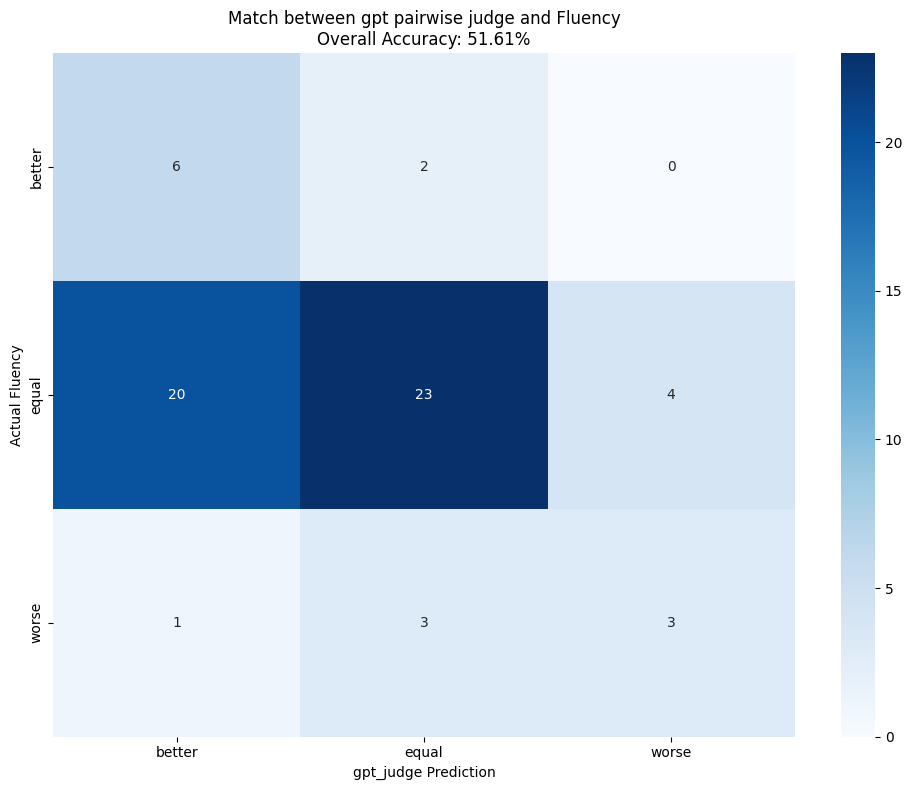

In [55]:
# Create a confusion matrix
conf_matrix = confusion_matrix(danish['Fluency'], danish['gpt_judge'], labels=sorted(danish['Fluency'].unique()))

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(
    conf_matrix,
    index=sorted(danish['Fluency'].unique()),
    columns=sorted(danish['Fluency'].unique())
)

# Calculate accuracy (diagonal values are matches)
match_percentage = (danish['gpt_judge'] == danish['Fluency']).mean() * 100

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'Match between gpt pairwise judge and Fluency\nOverall Accuracy: {match_percentage:.2f}%')
plt.xlabel('gpt_judge Prediction')
plt.ylabel('Actual Fluency')
plt.tight_layout()
plt.show()


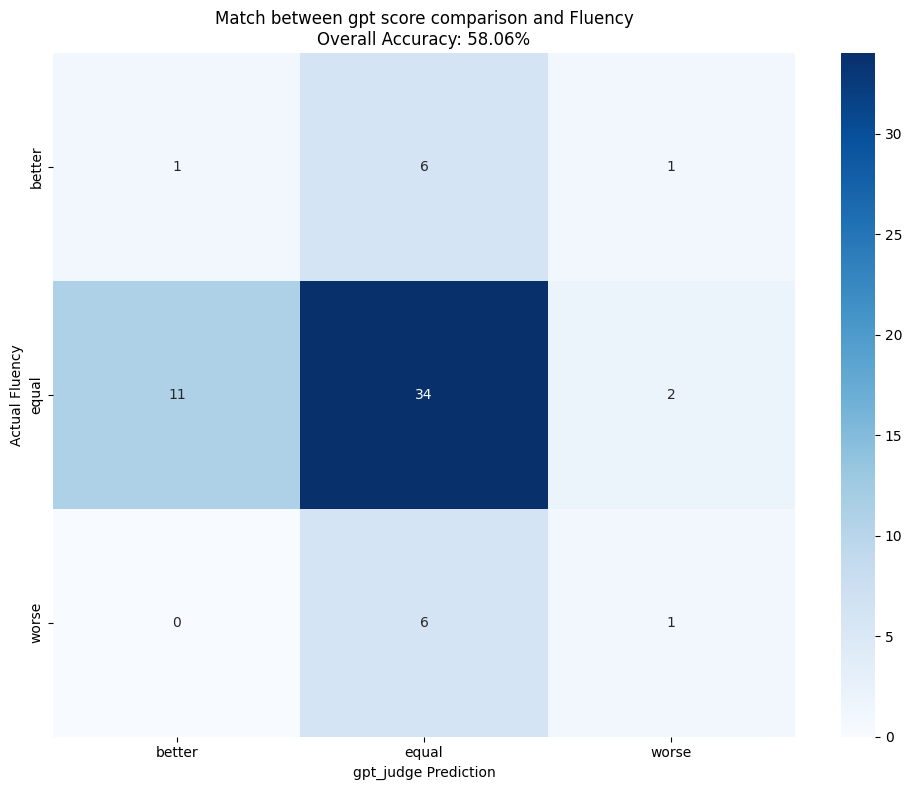

In [54]:
# Create a confusion matrix
conf_matrix = confusion_matrix(danish['Fluency'], danish['gpt_score_comparison'], labels=sorted(danish['Fluency'].unique()))

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(
    conf_matrix,
    index=sorted(danish['Fluency'].unique()),
    columns=sorted(danish['Fluency'].unique())
)

# Calculate accuracy (diagonal values are matches)
match_percentage = (danish['gpt_score_comparison'] == danish['Fluency']).mean() * 100

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'Match between gpt score comparison and Fluency\nOverall Accuracy: {match_percentage:.2f}%')
plt.xlabel('gpt_judge Prediction')
plt.ylabel('Actual Fluency')
plt.tight_layout()
plt.show()


# flores dev

In [ ]:
"""df = pd.read_json('/scratch/project_462000353/jburdge/git/compare_translations/flores/output/flores200_devtest_viking-33b_eng_dan_temp0.jsonl', lines=True)
df = df.explode('translations')
df.rename(columns= {'translations': 'viking_translation'}, inplace=True)"""

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
checkpoint = 'facebook/nllb-200-distilled-600M'
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

In [70]:
target_lang = 'dan_Latn'
source_lang = 'eng_Latn'

translator = pipeline('translation', model=model, tokenizer=tokenizer, src_lang=source_lang, tgt_lang=target_lang, max_length = 400)

Device set to use cpu


In [ ]:
df['nllb_translation'] = df['source_sentence'].progress_map(lambda x: translator(x)[0]['translation_text'])

# chrf scores
df['viking_chrf'] = df.progress_apply(lambda x: chrf.compute(predictions=[x['viking_translation']], references=[[x['target_sentence']]])['score'], axis=1)
df['fasttext_chrf'] = df.progress_apply(lambda x: chrf.compute(predictions=[x['nllb_translation']], references=[[x['target_sentence']]])['score'], axis=1)


100%|██████████| 997/997 [00:18<00:00, 53.75it/s]


In [ ]:
#df['gemini_flash_minimal_edits_output'] = df['nllb_translation'].progress_map(lambda x: gemini_chat(create_edit_prompt(x)))

df['gemini_flash_minimal_edits'] = df['gemini_flash_minimal_edits_output'].map(
    lambda x: BeautifulSoup(x, 'html.parser').find('edited_sentence').text 
    if isinstance(x, str) and BeautifulSoup(x, 'html.parser').find('edited_sentence') 
    else None)

df = df.dropna(subset=['gemini_flash_minimal_edits'] ,axis=0)
df['gemini_flash_minimal_edits_chrf'] = df.progress_apply(lambda x: chrf.compute(predictions=[x['gemini_flash_minimal_edits']], references=[[x['target_sentence']]])['score'], axis=1)

df['gemini_flash_translation'] = df['source_sentence'].progress_map(lambda x: gemini_chat(create_translation_prompt(x)))
df = df.dropna(subset=['gemini_flash_translation'] ,axis=0)

df['gemini_flash_chrf'] = df.progress_apply(lambda x: chrf.compute(predictions=[x['gemini_flash_translation']], references=[[x['target_sentence']]])['score'], axis=1)

df['gpt4o_minimal_edits_output'] = df['nllb_translation'].progress_map(lambda x: call_litellm(create_edit_prompt(x), 'gpt-4o').choices[0].message.content )

df['gpt4o_minimal_edits'] = df['gpt4o_minimal_edits_output'].map(
    lambda x: BeautifulSoup(x, 'html.parser').find('edited_sentence').text 
    if isinstance(x, str) and BeautifulSoup(x, 'html.parser').find('edited_sentence') 
    else None
)
df = df.dropna(subset=['gpt4o_minimal_edits'] ,axis=0)

df['minimal_edits_chrf'] = df.progress_apply(lambda x: chrf.compute(predictions=[x['gpt4o_minimal_edits']], references=[[x['target_sentence']]])['score'], axis=1)

100%|██████████| 988/988 [20:35<00:00,  1.25s/it]
/tmp/ipykernel_37625/3619969944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gemini_flash_minimal_edits_output'] = df['fasttext_translation'].progress_map(lambda x: gemini_chat(create_edit_prompt(x)))
/tmp/ipykernel_37625/3619969944.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gemini_flash_minimal_edits'] = df['gemini_flash_minimal_edits_output'].map(


In [13]:
df['gemini_flash_extensive_edits_viking'] = df['viking_translation'].progress_map(lambda x: gemini_chat(extensive_edits_prompt(x)))
df = df.dropna(subset=['gemini_flash_extensive_edits_viking'] ,axis=0)

df['gpt4o_rating_of_extensive_gemini_edits_of_viking'] = df['gemini_flash_extensive_edits_viking'].progress_map(lambda x: call_litellm(create_fluency_prompt(x), 'gpt-4o').choices[0].message.content)
df['gpt4o_rating_of_extensive_gemini_edits_of_viking_score'] = df['gpt4o_rating_of_extensive_gemini_edits_of_viking'].map(
    lambda x: int(BeautifulSoup(x, 'html.parser').find('score').text.split('/')[0])
    if isinstance(x, str) and BeautifulSoup(x, 'html.parser').find('score') 
    else None)


100%|██████████| 954/954 [53:15<00:00,  3.35s/it]  


In [ ]:
df['gpt4o_extensive_edits_viking'] = df['viking_translation'].progress_map(lambda x: call_litellm(extensive_edits_prompt(x), 'gpt-4o').choices[0].message.content)
df = df.dropna(subset=['gpt4o_extensive_edits_viking'] ,axis=0)


100%|██████████| 954/954 [12:47<00:00,  1.24it/s]


In [ ]:
df['gpt4o_rating_of_extensive_gpt4o_of_viking'] = df['gpt4o_extensive_edits_viking'].progress_map(lambda x: call_litellm(create_fluency_prompt(x), 'gpt-4o').choices[0].message.content)
df['gpt4o_rating_of_extensive_gpt4o_of_viking_score'] = df['gpt4o_rating_of_viking'].map(
    lambda x: int(BeautifulSoup(x, 'html.parser').find('score').text.split('/')[0])
    if isinstance(x, str) and BeautifulSoup(x, 'html.parser').find('score') 
    else None)

100%|██████████| 954/954 [50:24<00:00,  3.17s/it]  


In [ ]:
#df.to_json('/scratch/project_462000353/maribarr/FastChat/fastchat/llm_judge/data/flores/flores_dev_fasttext.jsonl', orient='records', lines=True)

In [5]:
df = pd.read_json('/scratch/project_462000353/maribarr/FastChat/fastchat/llm_judge/data/flores/flores_dev_fasttext.jsonl', lines=True)

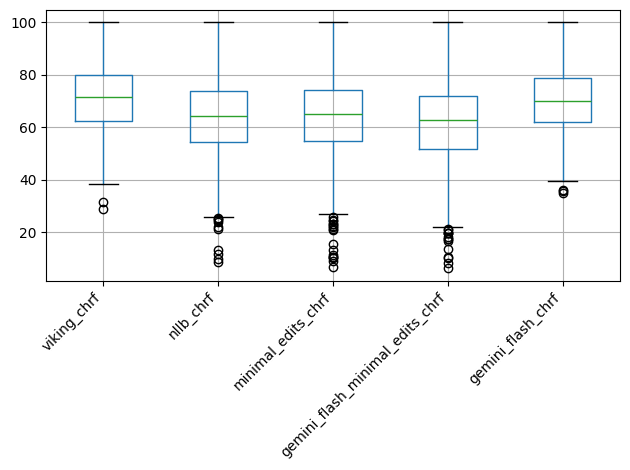

In [203]:
ax = df[['viking_chrf', 'nllb_chrf', 'minimal_edits_chrf', 'gemini_flash_minimal_edits_chrf', 'gemini_flash_chrf']].boxplot()
# Rotate the x-tick labels
plt.xticks(rotation=45, ha='right')  # 'ha' is for horizontal alignment

# Optional: Adjust the plot layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
df['gpt4o_rating_of_viking'] = df.viking_translation.progress_map(lambda x: call_litellm(create_fluency_prompt(x), 'gpt-4o').choices[0].message.content)
df['gpt4o_fluency_score_viking'] = df['gpt4o_rating_of_viking'].map(
    lambda x: int(BeautifulSoup(x, 'html.parser').find('score').text.split('/')[0])
    if isinstance(x, str) and BeautifulSoup(x, 'html.parser').find('score') 
    else None
)
df = df.dropna(subset=['gpt4o_fluency_score_viking'], axis=0)

df['gpt4o_rating_of_gemini'] = df.gemini_flash_translation.progress_map(lambda x: call_litellm(create_fluency_prompt(x), 'gpt-4o').choices[0].message.content)

df['gpt4o_fluency_score_gemini_flash'] = df['gpt4o_rating_of_gemini'].map(
    lambda x: int(BeautifulSoup(x, 'html.parser').find('score').text.split('/')[0])
    if isinstance(x, str) and BeautifulSoup(x, 'html.parser').find('score') 
    else None
)
df = df.dropna(subset=['gpt4o_fluency_score_gemini_flash'], axis=0)

df['gpt4o_fluency_score_gemini_flash'] = df['gpt4o_rating_of_gemini'].map(
    lambda x: int(BeautifulSoup(x, 'html.parser').find('score').text.split('/')[0])
    if isinstance(x, str) and BeautifulSoup(x, 'html.parser').find('score') 
    else None
)
df = df.dropna(subset=['gpt4o_fluency_score_gemini_flash'], axis=0)

/tmp/ipykernel_37625/40058735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gpt4o_fluency_score_viking'] = df['gpt4o_rating_of_viking'].map(


In [3]:
df[['gpt4o_fluency_score_viking', 'gpt4o_fluency_score_gemini_flash']].describe()

,gpt4o_fluency_score_viking,gpt4o_fluency_score_gemini_flash
count,954.000000,954.000000
mean,2.613208,2.660377
std,0.597541,0.543938
min,1.000000,1.000000
25%,2.000000,2.000000
50%,3.000000,3.000000
75%,3.000000,3.000000
max,3.000000,4.000000


In [250]:
df.loc[df.gpt4o_fluency_score_viking == 3, 'viking_translation']

1                                                 Ledende forskere siger, at dette kan bringe tidlig opdagelse af kræft, tuberkulose, HIV og malaria til patienter i lavindkomstlande, hvor overlevelsesraten for sygdomme som brystkræft kan være halvdelen af de rigere landes.
2                                                                                                                   JAS 39C Gripen styrtede ned på en landingsbane omkring kl. 9:30 lokal tid (0230 UTC) og eksploderede, hvilket lukkede lufthavnen for kommercielle flyvninger.
3                                                                                                                                                                                                                Piloten blev identificeret som eskadrillechef Dilokrit Pattavee.
4                                                                                                                                                               Lokale medier rapp

In [251]:
df.loc[df.gpt4o_fluency_score_gemini_flash == 3, 'gemini_flash_translation']

0          Mandag annoncerede forskere fra Stanford University School of Medicine opfindelsen af et nyt diagnostisk værktøj, der kan sortere celler efter type: en lille, printbar chip, der muligvis kan fremstilles for omkring én amerikansk cent stykket ved hjælp af standard inkjetprintere.\n
1                                                        Førende forskere siger, at dette kan føre til tidlig diagnosticering af kræft, tuberkulose, HIV og malaria hos patienter i lavindkomstlande, hvor overlevelsesraten for sygdomme som brystkræft kan være halvt så høj som i rigere lande.\n
2                                                                                                                                 En JAS 39C Gripen styrtede ned på en landingsbane omkring kl. 9:30 lokal tid (0230 UTC) og eksploderede, hvilket lukkede lufthavnen for kommercielle flyvninger.\n
3                                                                                                                        